# Saving Array Quantities

## Overview

### Questions

* How can I save per-particle quantities for later analysis?
* How can I access that data?

### Objectives

* Show how to log **per-particle properties** to a **GSD** file.
* Explain how to read logged quantities from a **GSD** file.
* Mention that OVITO reads these quantities.

## Boilerplate Code

In [1]:
import gsd.hoomd
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
import os

fn = os.path.join(os.getcwd(), "trajectory.gsd")
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [3]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import math

import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)


def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]),
        roughness=0.5,
        primitive_color_mix=1.0,
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    energies = snapshot.log["particles/md/pair/LJ/energies"]
    mapper = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(
            vmin=numpy.min(energies), vmax=numpy.max(energies), clip=True
        ),
        cmap=matplotlib.colormaps["viridis"],
    )
    geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))

    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, L + 1), look_at=(0, 0, 0), up=(0, 1, 0), height=L + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

## General Array Quantities

You logged scalar and array quantities to a HDF5 file in the previous section. HDF5 is the ideal format to log this type of data, as it produces small files that can be read quickly.

## Array Quantities Coupled With a Trajectory

You can also log scalar, array, per-particle (e.g. energy and force), and other quantities in a **GSD** file _along with the trajectory_.
Then you can use utilize the data in your analysis and visualization workflow, such as using [OVITO](https://www.ovito.org/) to color particles by energy or display force vectors.
When using OVITO, open the **GSD** file and all logged quantities will be available in the inspector and for use in the pipeline.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dynamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(
    filename="../01-Introducing-Molecular-Dynamics/random.gsd"
)

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator
simulation.run(0)

## Logging Per-Particle Quantities

MD forces provide a number of loggable quantities including their contribution to the system energy, but also per-particle energy contributions (in `energies`) and per-particle forces, torques, and virials.

In [5]:
lj.loggables

{'energy': 'scalar',
 'energies': 'particle',
 'additional_energy': 'scalar',
 'forces': 'particle',
 'torques': 'particle',
 'virials': 'particle',
 'additional_virial': 'sequence'}

Add the per-particle LJ energies and forces to a logger:

In [6]:
logger = hoomd.logging.Logger()
logger.add(lj, quantities=["energies", "forces"])

## Writing Per-Particle Quantities to a GSD File

Create the **GSD** writer to write the simulation trajectory:

In [7]:
gsd_writer = hoomd.write.GSD(
    filename="trajectory.gsd",
    trigger=hoomd.trigger.Periodic(10000),
    mode="xb",
    filter=hoomd.filter.All(),
)
simulation.operations.writers.append(gsd_writer)

Set the `logger` attribute and **GSD** will also store the selected quantities.

In [8]:
gsd_writer.logger = logger

Run the simulation:

In [9]:
simulation.run(100000)

Flush the GSD buffer so it is readable in the next code cell. In typical workflows, you will run separate simulation and analysis scripts and the buffered writes will automatically flush when your simulation script exits.

In [10]:
gsd_writer.flush()

## Reading Logged Data From a GSD File

Use the `gsd` package to open the file:

In [11]:
traj = gsd.hoomd.open("trajectory.gsd", mode="r")

The log data for a specific frame is stored in the `log` dictionary for that frame.

In [12]:
traj[0].log.keys()

dict_keys(['particles/md/pair/LJ/energies', 'particles/md/pair/LJ/forces'])

GSD prepends `particles/` to the logged name of per-particle quantities. The quantities are NumPy arrays with `N_particles` elements. Here are a few slices:

In [13]:
traj[-1].log["particles/md/pair/LJ/energies"][0:10]

array([-1.5447698 , -1.86000674, -2.59625565, -2.15663811, -2.38797374,
       -2.284496  , -1.97509388, -2.55398389, -2.34368619, -2.4401767 ])

In [14]:
traj[-1].log["particles/md/pair/LJ/forces"][0:10]

array([[-48.12881616,  23.08448541,  10.12548583],
       [  1.88172396,  -0.1473973 ,   2.24157358],
       [ -0.11767867,   0.14484154,  -0.3137114 ],
       [  2.54291568,  -1.15416658,   0.71322065],
       [ -1.83084406,  -0.16967043,   2.73259914],
       [ -3.27433324,   1.66045855,  -0.54877679],
       [  2.20655196,  -0.28725273, -10.22337495],
       [ -4.40971462,   2.90268415,   8.92368957],
       [ -1.66725157,   1.17369565,   4.59137068],
       [ 27.49519427,  19.27891525, -12.56981981]])

You can use these arrays as inputs to any computation or plotting tools:

In [15]:
numpy.mean(traj[-1].log["particles/md/pair/LJ/forces"], axis=0)

array([-2.48065457e-16, -2.00360561e-16, -5.20417043e-17])

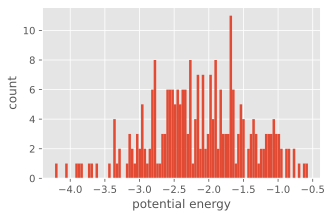

In [16]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.hist(traj[-1].log["particles/md/pair/LJ/energies"], 100)
ax.set_xlabel("potential energy")
ax.set_ylabel("count")
fig

As with scalar quantities, the array quantities are stored separately in each frame.
Use a loop to access a range of frames and compute time-series data or averages.

This is what the system looks like when you color the particles by the values in `particles/md/pair/LJ/energies`:

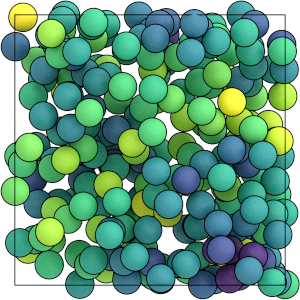

In [17]:
render(traj[-1])

In this section, you have logged per-particle quantities to a GSD file during a simulation run and accessed that data with a script.
The next section of this tutorial demonstrates how to log particle shape information that OVITO can use.